# Forced Alignment With Wav2Vec2
link: https://pytorch.org/tutorials/intermediate/forced_alignment_with_torchaudio_tutorial.html

In [1]:
# %matplotlib inline

import os
from dataclasses import dataclass

import torch
import torchaudio
import requests
import matplotlib
import matplotlib.pyplot as plt
import IPython

matplotlib.rcParams['figure.figsize'] = [16.0, 4.8]

torch.random.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(torch.__version__)
print(torchaudio.__version__)
print(device)

SPEECH_URL = 'https://download.pytorch.org/torchaudio/tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav'
SPEECH_FILE = '_assets/speech.wav'

if not os.path.exists(SPEECH_FILE):
  os.makedirs('_assets', exist_ok=True)
  with open(SPEECH_FILE, 'wb') as file:
    file.write(requests.get(SPEECH_URL).content)

1.10.2
0.10.2
cpu


In [6]:
# generate the label class porbability of each audio frame. 

bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model = bundle.get_model().to(device)
labels = bundle.get_labels()
with torch.inference_mode():
    waveform, _ = torchaudio.load(SPEECH_FILE)
    emissions, _ = model(waveform.to(device))
    emissions = torch.log_softmax(emissions, dim=-1) # compute probability in log-domain to avoid numerical instability. 

emission = emissions[0].cpu().detach()

<bound method Wav2Vec2ASRBundle.get_labels of Wav2Vec2ASRBundle(_path='wav2vec2_fairseq_base_ls960_asr_ls960.pth', _params={'extractor_mode': 'group_norm', 'extractor_conv_layer_config': [(512, 10, 5), (512, 3, 2), (512, 3, 2), (512, 3, 2), (512, 3, 2), (512, 2, 2), (512, 2, 2)], 'extractor_conv_bias': False, 'encoder_embed_dim': 768, 'encoder_projection_dropout': 0.1, 'encoder_pos_conv_kernel': 128, 'encoder_pos_conv_groups': 16, 'encoder_num_layers': 12, 'encoder_num_heads': 12, 'encoder_attention_dropout': 0.1, 'encoder_ff_interm_features': 3072, 'encoder_ff_interm_dropout': 0.0, 'encoder_dropout': 0.1, 'encoder_layer_norm_first': False, 'encoder_layer_drop': 0.05, 'aux_num_out': 32}, _sample_rate=16000, _labels=('|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z'))>


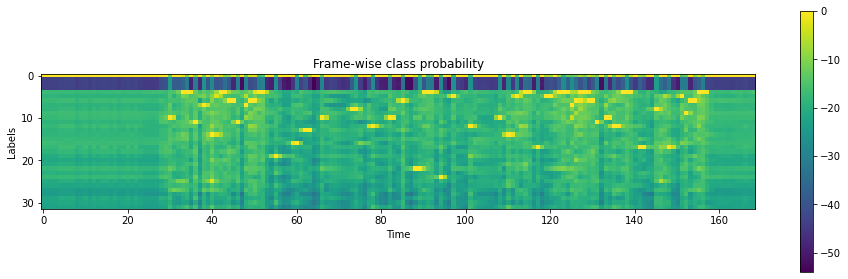

In [4]:
# visualization 

print(labels)
plt.imshow(emission.T)
plt.colorbar()
plt.title("Frame-wise class probability")
plt.xlabel("Time")
plt.ylabel("Labels")
plt.show()


In [7]:
transcript = 'I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT'
dictionary = {c: i for i, c in enumerate(labels)}

tokens = [dictionary[c] for c in transcript]
print(list(zip(transcript, tokens)))

def get_trellis(emission, tokens, blank_id=0):
    num_frame = emission.size(0)
    num_tokens = len(tokens)

    # Trellic has extra diemsions for both time axis aand tokens. 
    # The extra dim for token represents <SoS> (start-of-sentence)
    # The extra dim for time axis is for simplification of the code. 
    trellis = torch.full((num_frame+1, num_tokens+1), -float('inf'))
    trellis[:, 0] = 0
    for t in range(num_frame):
        trellis[t+1, 1:] = torch.maximum(
            # Score for staying at the same token
            trellis[t, 1:] + emission[t, blank_id], 
            # score for changing to the next token
            trellis[t, :-1] + emission[t, tokens],
        )
    return trellis

trellis = get_trellis(emission, tokens)

[('I', 10), ('|', 4), ('H', 11), ('A', 7), ('D', 14), ('|', 4), ('T', 6), ('H', 11), ('A', 7), ('T', 6), ('|', 4), ('C', 19), ('U', 16), ('R', 13), ('I', 10), ('O', 8), ('S', 12), ('I', 10), ('T', 6), ('Y', 22), ('|', 4), ('B', 24), ('E', 5), ('S', 12), ('I', 10), ('D', 14), ('E', 5), ('|', 4), ('M', 17), ('E', 5), ('|', 4), ('A', 7), ('T', 6), ('|', 4), ('T', 6), ('H', 11), ('I', 10), ('S', 12), ('|', 4), ('M', 17), ('O', 8), ('M', 17), ('E', 5), ('N', 9), ('T', 6)]


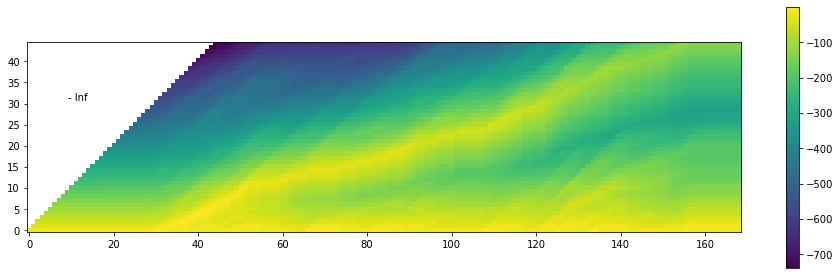

In [8]:
# visualization 

plt.imshow(trellis[1:, 1:].T, origin='lower')
plt.annotate("- Inf", (trellis.size(1) / 5, trellis.size(1) / 1.5))
plt.colorbar()
plt.show()

In [9]:
# traaverse back in time to grab highest probablility 

@dataclass
class Point:
    token_index: int 
    time_index: int 
    score: float 

def backtrack(trellis, emission, tokens, blank_id=0):

    # note: 
    # j and t are indicies for trellis, which has extra dimensions
    # for time and tokens at the begining. 
    # When refering to time frame index 'T' in trellis,
    # the corresponding index in emission is 'T-1'. 
    # similarly, when refring to token index 'j' in trellis, 
    # the correspondionf index in transxipt is 'J-1'. 
    j= trellis.size(1) - 1
    t_start = torch.argmax(trellis[:, j]).item()

    path =  []
    for t in range(t_start, 0, -1): 
        # 1. Figure out if the current position was stay or change
        # Note (again):
        # `emission[J-1]` is the emission at time frame `J` of trellis dimension.
        # Score for token staying the same from time frame J-1 to T.
        stayed = trellis[t-1, j] + emission[t-1, blank_id]
        # score for token changing from C-1 at T-1 to J at T. 
        changed = trellis[t-1, j-1] + emission[t-1, tokens[j-1]]

        # 2. Store the path with frame-wise probability. 
        prob = emission[t-1, tokens[j-1] if changed > stayed else 0].exp().item()
        # Return token index and time index in non-trellis coordinate. 
        path.append(Point(j-1, t-1, prob)) 

        # 3. Update the token 
        if changed > stayed: 
            j -= 1
            if j ==0: 
                break 
    else: 
        raise ValueError('Failed to align')
    return path[::-1]

path = backtrack(trellis, emission, tokens)
print(path)

[Point(token_index=0, time_index=30, score=0.9999842643737793), Point(token_index=0, time_index=31, score=0.984698474407196), Point(token_index=0, time_index=32, score=0.9999707937240601), Point(token_index=0, time_index=33, score=0.15398810803890228), Point(token_index=1, time_index=34, score=0.9999173879623413), Point(token_index=1, time_index=35, score=0.6080924272537231), Point(token_index=2, time_index=36, score=0.9997720122337341), Point(token_index=2, time_index=37, score=0.999713122844696), Point(token_index=3, time_index=38, score=0.9999357461929321), Point(token_index=3, time_index=39, score=0.9861553311347961), Point(token_index=4, time_index=40, score=0.9238579273223877), Point(token_index=4, time_index=41, score=0.9257457256317139), Point(token_index=4, time_index=42, score=0.015664231032133102), Point(token_index=5, time_index=43, score=0.9998378753662109), Point(token_index=6, time_index=44, score=0.9988443851470947), Point(token_index=6, time_index=45, score=0.101491615

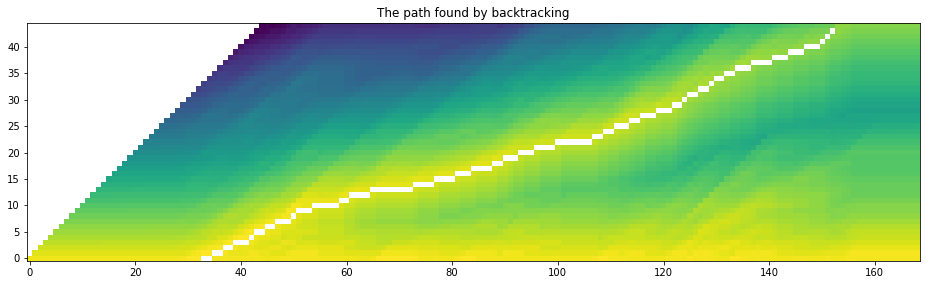

In [10]:
def plot_trellis_with_path(trellis, path):
  # To plot trellis with path, we take advantage of 'nan' value
  trellis_with_path = trellis.clone()
  for i, p in enumerate(path):
    trellis_with_path[p.time_index, p.token_index] = float('nan')
  plt.imshow(trellis_with_path[1:, 1:].T, origin='lower')

plot_trellis_with_path(trellis, path)
plt.title("The path found by backtracking")
plt.show()

In [11]:
# average probability for the merged segments 

# merge the labels 
@dataclass
class Segment:
    label: str 
    start: int
    end: int
    score: float


    def __repr__(self):
        return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

    @property
    def length(self):
        return self.end - self.start

def merge_repeats(path):
    i1, i2 = 0, 0
    segments = []
    while i1 < len(path):
        while i2 < len(path) and path[i1].token_index == path[i2].token_index:
            i2 += 1
        score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
        segments.append(Segment(transcript[path[i1].token_index], path[i1].time_index, path[i2-1].time_index + 1, score))
        i1 = i2
    return segments

segments = merge_repeats(path)
for seg in segments:
    print(seg)

I	(0.78): [   30,    34)
|	(0.80): [   34,    36)
H	(1.00): [   36,    38)
A	(0.99): [   38,    40)
D	(0.62): [   40,    43)
|	(1.00): [   43,    44)
T	(0.55): [   44,    46)
H	(1.00): [   46,    48)
A	(0.37): [   48,    51)
T	(0.00): [   51,    52)
|	(1.00): [   52,    55)
C	(0.97): [   55,    60)
U	(1.00): [   60,    62)
R	(0.75): [   62,    66)
I	(0.88): [   66,    74)
O	(0.99): [   74,    78)
S	(1.00): [   78,    82)
I	(0.89): [   82,    85)
T	(0.78): [   85,    89)
Y	(0.70): [   89,    91)
|	(0.66): [   91,    94)
B	(1.00): [   94,    97)
E	(1.00): [   97,   101)
S	(1.00): [  101,   108)
I	(1.00): [  108,   110)
D	(0.93): [  110,   112)
E	(0.66): [  112,   115)
|	(1.00): [  115,   117)
M	(0.67): [  117,   120)
E	(0.67): [  120,   123)
|	(0.50): [  123,   125)
A	(0.98): [  125,   126)
T	(0.50): [  126,   128)
|	(0.51): [  128,   130)
T	(1.00): [  130,   131)
H	(1.00): [  131,   133)
I	(0.75): [  133,   135)
S	(0.36): [  135,   138)
|	(0.50): [  138,   142)
M	(1.00): [  142,   145)


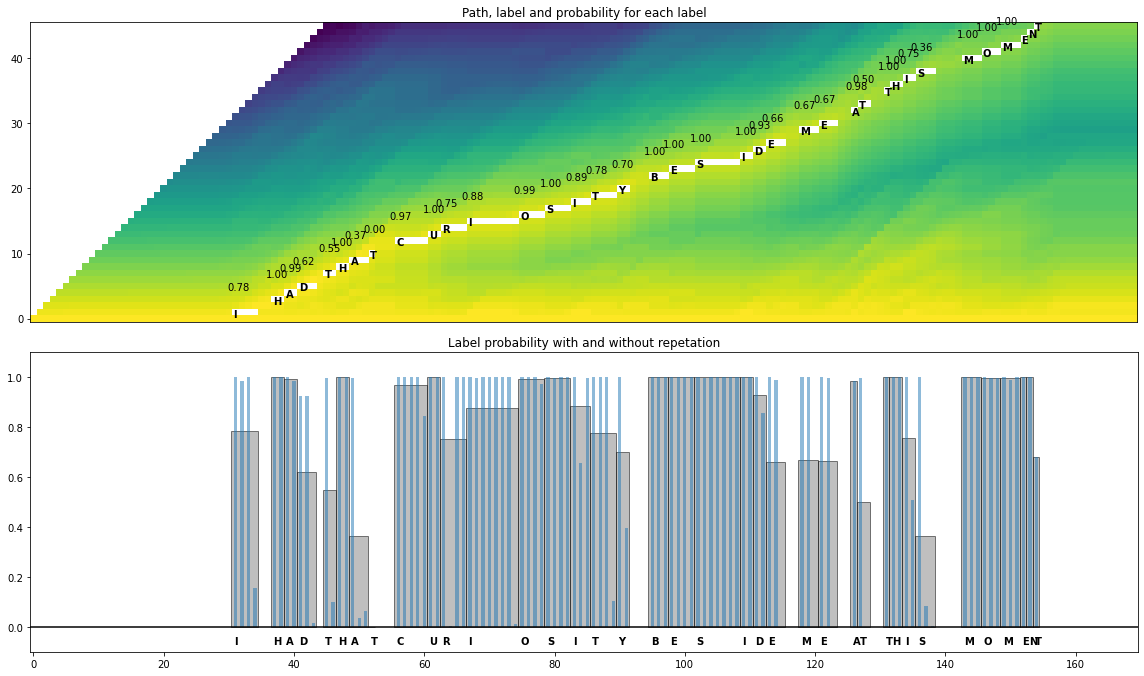

In [12]:
def plot_trellis_with_segments(trellis, segments, transcript):
  # To plot trellis with path, we take advantage of 'nan' value
  trellis_with_path = trellis.clone()
  for i, seg in enumerate(segments):
    if seg.label != '|':
      trellis_with_path[seg.start+1:seg.end+1, i+1] = float('nan')

  fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9.5))
  ax1.set_title("Path, label and probability for each label")
  ax1.imshow(trellis_with_path.T, origin='lower')
  ax1.set_xticks([])

  for i, seg in enumerate(segments):
    if seg.label != '|':
      ax1.annotate(seg.label, (seg.start + .7, i + 0.3), weight='bold')
      ax1.annotate(f'{seg.score:.2f}', (seg.start - .3, i + 4.3))

  ax2.set_title("Label probability with and without repetation")
  xs, hs, ws = [], [], []
  for seg in segments:
    if seg.label != '|':
      xs.append((seg.end + seg.start) / 2 + .4)
      hs.append(seg.score)
      ws.append(seg.end - seg.start)
      ax2.annotate(seg.label, (seg.start + .8, -0.07), weight='bold')
  ax2.bar(xs, hs, width=ws, color='gray', alpha=0.5, edgecolor='black')

  xs, hs = [], []
  for p in path:
    label = transcript[p.token_index]
    if label != '|':
      xs.append(p.time_index + 1)
      hs.append(p.score)

  ax2.bar(xs, hs, width=0.5, alpha=0.5)
  ax2.axhline(0, color='black')
  ax2.set_xlim(ax1.get_xlim())
  ax2.set_ylim(-0.1, 1.1)

plot_trellis_with_segments(trellis, segments, transcript)
plt.tight_layout()
plt.show()

In [13]:
# Then, finally, we segment the original audio into segmented audio and listen to them to see if the segmentation is correct.

In [14]:
# Merge words
def merge_words(segments, separator='|'):
  words = []
  i1, i2 = 0, 0
  while i1 < len(segments):
    if i2 >= len(segments) or segments[i2].label == separator:
      if i1 != i2:
        segs = segments[i1:i2]
        word = ''.join([seg.label for seg in segs])
        score = sum(seg.score * seg.length for seg in segs) / sum(seg.length for seg in segs)
        words.append(Segment(word, segments[i1].start, segments[i2-1].end, score))
      i1 = i2 + 1
      i2 = i1
    else:
      i2 += 1
  return words

word_segments = merge_words(segments)
for word in word_segments:
  print(word)

I	(0.78): [   30,    34)
HAD	(0.84): [   36,    43)
THAT	(0.52): [   44,    52)
CURIOSITY	(0.89): [   55,    91)
BESIDE	(0.94): [   94,   115)
ME	(0.67): [  117,   123)
AT	(0.66): [  125,   128)
THIS	(0.70): [  130,   138)
MOMENT	(0.97): [  142,   154)


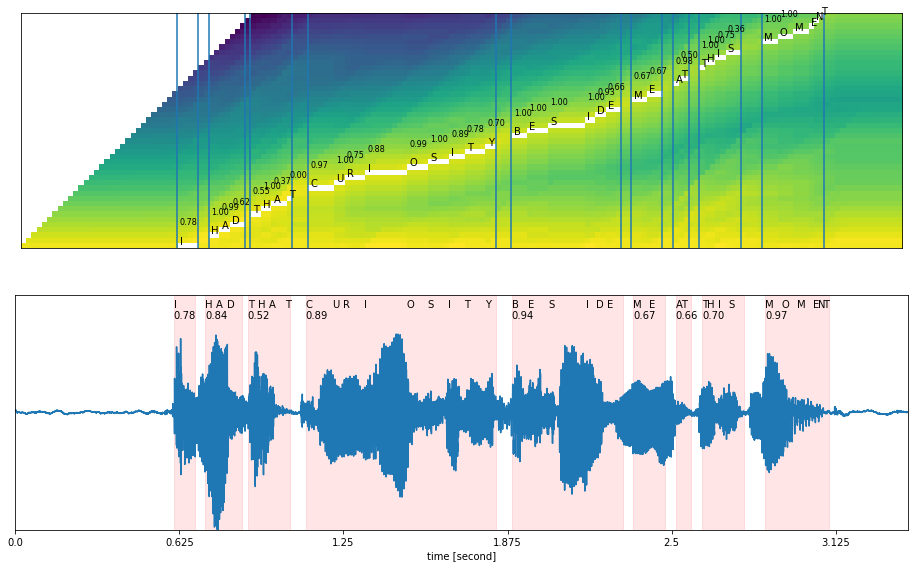

In [15]:
def plot_alignments(trellis, segments, word_segments, waveform):
  trellis_with_path = trellis.clone()
  for i, seg in enumerate(segments):
    if seg.label != '|':
      trellis_with_path[seg.start+1:seg.end+1, i+1] = float('nan')

  fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9.5))

  ax1.imshow(trellis_with_path[1:, 1:].T, origin='lower')
  ax1.set_xticks([])
  ax1.set_yticks([])

  for word in word_segments:
    ax1.axvline(word.start - 0.5)
    ax1.axvline(word.end - 0.5)

  for i, seg in enumerate(segments):
    if seg.label != '|':
      ax1.annotate(seg.label, (seg.start, i + 0.3))
      ax1.annotate(f'{seg.score:.2f}', (seg.start , i + 4), fontsize=8)

  # The original waveform
  ratio = waveform.size(0) / (trellis.size(0) - 1)
  ax2.plot(waveform)
  for word in word_segments:
    x0 = ratio * word.start
    x1 = ratio * word.end
    ax2.axvspan(x0, x1, alpha=0.1, color='red')
    ax2.annotate(f'{word.score:.2f}', (x0, 0.8))

  for seg in segments:
    if seg.label != '|':
      ax2.annotate(seg.label, (seg.start * ratio, 0.9))
  xticks = ax2.get_xticks()
  plt.xticks(xticks, xticks / bundle.sample_rate)
  ax2.set_xlabel('time [second]')
  ax2.set_yticks([])
  ax2.set_ylim(-1.0, 1.0)
  ax2.set_xlim(0, waveform.size(-1))

plot_alignments(trellis, segments, word_segments, waveform[0],)
plt.show()

# A trick to embed the resulting audio to the generated file.
# `IPython.display.Audio` has to be the last call in a cell,
# and there should be only one call par cell.
def display_segment(i):
  ratio = waveform.size(1) / (trellis.size(0) - 1)
  word = word_segments[i]
  x0 = int(ratio * word.start)
  x1 = int(ratio * word.end)
  filename = f"_assets/{i}_{word.label}.wav"
  torchaudio.save(filename, waveform[:, x0:x1], bundle.sample_rate)
  print(f"{word.label} ({word.score:.2f}): {x0 / bundle.sample_rate:.3f} - {x1 / bundle.sample_rate:.3f} sec")
  return IPython.display.Audio(filename)

In [16]:
# Generate the audio for each segment
print(transcript)
IPython.display.Audio(SPEECH_FILE)

I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT


In [17]:
display_segment(0)


I (0.78): 0.604 - 0.684 sec
